### Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('News_Category_Dataset_v3.csv')

print(df.head())

   Unnamed: 0                                           headline   category  \
0           0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1           1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2           2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3           3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4           4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

         date  headline_length  short_description_length

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, correcting spelling, standardizing, handling contractions, and lemtization.

In [3]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

# clean data
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_description'] = df['short_description'].apply(clean_text)

C:\Users\Yue\AppData\Local\Temp\ipykernel_17552\4207609330.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.3 Perform text tokenization and vectorization using TF-IDF.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

tfidf_vectorizer = TfidfVectorizer()

tfidf_headline = tfidf_vectorizer.fit_transform(df['cleaned_headline'])
# df_headline_tfidf = pd.DataFrame(tfidf_headline.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_headline_tfidf = df_headline_tfidf.add_prefix('headline_')

tfidf_description = tfidf_vectorizer.fit_transform(df['cleaned_description'])
# df_description_tfidf = pd.DataFrame(tfidf_description.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_description_tfidf = df_description_tfidf.add_prefix('description_')

# df = pd.concat([df, df_headline_tfidf, df_description_tfidf], axis=1)
tfidf= hstack([tfidf_headline,tfidf_description])

1.4 Extract and analyze different features from the text that might be useful for classification, such as word count,
sentence length, n-grams, etc

In [5]:
#pip install category_encoders

from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# change date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# word count
df['headline_word_count'] = df['headline'].apply(lambda x: len(str(x).split()))
df['description_word_count'] = df['short_description'].apply(lambda x: len(str(x).split()))

# encode authors using Binary encoding
encoder = BinaryEncoder(cols=['authors'], return_df=True)
df_encoded = encoder.fit_transform(df['authors'])
df_encoded_sparse = csr_matrix(df_encoded.values)

# drop extra columns
selected_columns = ['year', 'month', 'day', 'headline_length', 'short_description_length', 'headline_word_count', 'description_word_count' ]
new_df = df[selected_columns].copy()
# combine
original_data = hstack([csr_matrix(new_df), df_encoded_sparse,tfidf])

# encode category using label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category']) # use for Logistic Regression, Random Forest, and XGBoost

y_categorical = pd.get_dummies(df['category']) # use for Artificial Neural Network and Convolutional Neural Network 

print(y)
print(y_categorical)
print(original_data)
print(len(set(y)))

[35 35  5 ... 28 28 28]
        ARTS  ARTS & CULTURE  BLACK VOICES  BUSINESS  COLLEGE  COMEDY  CRIME  \
0          0               0             0         0        0       0      0   
1          0               0             0         0        0       0      0   
2          0               0             0         0        0       1      0   
3          0               0             0         0        0       0      0   
4          0               0             0         0        0       0      0   
...      ...             ...           ...       ...      ...     ...    ...   
209522     0               0             0         0        0       0      0   
209523     0               0             0         0        0       0      0   
209524     0               0             0         0        0       0      0   
209525     0               0             0         0        0       0      0   
209526     0               0             0         0        0       0      0   

        CULTURE

In [6]:
# Dimensionality Reduction using TruncatedSVD (which is better for sparse matrix)
from sklearn.decomposition import TruncatedSVD
import numpy as np

n_components = 100
svd = TruncatedSVD(n_components=n_components)

reduced_data = svd.fit_transform(original_data)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = sum(svd.explained_variance_ratio_)
print(f"Cumulative explained variance ratio with {n_components} components: {cumulative_explained_variance_ratio:.4f}")


Cumulative explained variance ratio with 100 components: 0.9998


In [ ]:
import umap.umap_ as umap

# Create an instance of the UMAP model
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1,  n_components=2, metric='euclidean')

# Fit the model to your TF-IDF data and transform the data
reduced_data_umap = reducer.fit_transform(original_data)

In this part, we did dimensionality reduction useing TruncatedSVD. We chose 100 as n_components and get 99.98% cumulative explained variance ratio which effectively reduces the dimensionality of the data while retaining almost all of the information.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

X=reduced_data
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer size based on number of categories
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

history = model.fit(X_train_scaled, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

loss, accuracy, precision, recall = model.evaluate(X_test_scaled, y_test)
def f1_score(precision, recall):
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))
f1 = f1_score(precision, recall)

print(f"Test accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 42)                1386      
                                                                 
Total params: 9930 (38.79 KB)
Trainable params: 9930 (38.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


4191/4191 [==============================] - 8s 2ms/step - loss: 2.1643 - accuracy: 0.4335 - precision: 0.7534 - recall: 0.2404 - val_loss: 1.8827 - val_accuracy: 0.4950 - val_precision: 0.7761 - val_recall: 0.2903
Epoch 2/20
4191/4191 [==============================] - 

1310/1310 [==============================] - 4s 3ms/step


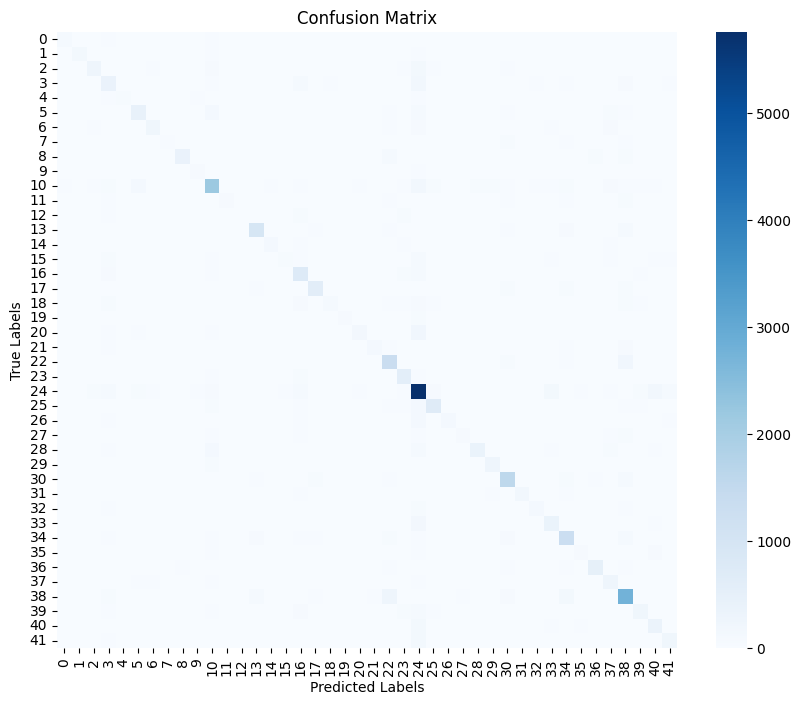

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_category_names = y_test.idxmax(axis=1)
y_test_classes = label_encoder.transform(y_test_category_names)
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
